# Medicare Stars Project

In [56]:
# I imported the data from Data.CMS.gov -- the Provider Information dataset. 
# Objective: to discover any existing trends in star ratings (overall quality) over time and investigate factors that affect the ratings-- in particular,
# health inspections, quality measures, and staffing.

### Data Analysis

#### Data Cleaning

In [57]:
%pip install scipy


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [58]:
import pandas as pd
import numpy as np
import altair as alt
import plotly.express as px
import os, json
import matplotlib.pyplot as plt 
from scipy.stats import f_oneway, permutation_test

provider_info = pd.read_csv('provider_info.csv')
provider_info.head()

CMS Certification Number (CCN)                                Provider Name  \
0                         015009                     BURNS NURSING HOME, INC.   
1                         015010               COOSA VALLEY HEALTHCARE CENTER   
2                         015012                   HIGHLANDS HEALTH AND REHAB   
3                         015014  EASTVIEW REHABILITATION & HEALTHCARE CENTER   
4                         015015                PLANTATION MANOR NURSING HOME   

              Provider Address     City/Town State  ZIP Code  \
0         701 MONROE STREET NW  RUSSELLVILLE    AL     35653   
1       260 WEST WALNUT STREET     SYLACAUGA    AL     35150   
2          380 WOODS COVE ROAD    SCOTTSBORO    AL     35768   
3     7755 FOURTH AVENUE SOUTH    BIRMINGHAM    AL     35206   
4  6450 OLD TUSCALOOSA HIGHWAY      MC CALLA    AL     35111   

   Telephone Number  Provider SSA County Code County/Parish  \
0        2563324110                       290      Franklin   
1        2562495604                       600     Talladega   
2        2562183708                       350       Jackson   
3        2058330146                       360     Jefferson   
4        2054776161                       360     Jefferson   

             Ownership Type  ...  \
0  For profit - Corporation  ...   
1  For profit - Corporation  ...   
2       Government - County  ...   
3   For profit - Individual  ...   
4   For profit - Individual  ...   

   Number of Citations from Infection Control Inspections  Number of Fines  \
0                                                NaN                     2   
1                                                0.0                     0   
2                                                NaN                     0   
3                                                0.0                     0   
4                                                NaN                     0   

   Total Amount of Fines in Dollars Number of Payment Denials  \
0                          24644.14                         0   
1                              0.00                         0   
2                              0.00                         0   
3                              0.00                         0   
4                              0.00                         0   

  Total Number of Penalties                                       Location  \
0                         2     701 MONROE STREET NW,RUSSELLVILLE,AL,35653   
1                         0      260 WEST WALNUT STREET,SYLACAUGA,AL,35150   
2                         0        380 WOODS COVE ROAD,SCOTTSBORO,AL,35768   
3                         0   7755 FOURTH AVENUE SOUTH,BIRMINGHAM,AL,35206   
4                         0  6450 OLD TUSCALOOSA HIGHWAY,MC CALLA,AL,35111   

  Latitude Longitude  Geocoding Footnote Processing Date  
0  34.5149   -87.736                 NaN      2024-07-01  
1  33.1637   -86.254                 NaN      2024-07-01  
2  34.6611   -86.047                 NaN      2024-07-01  
3  33.5595   -86.722                 NaN      2024-07-01  
4  33.3221   -87.034                 NaN      2024-07-01  

[5 rows x 103 columns]

In [59]:
# We have a lot of missing data! I will impute the NaN values by calculating the mean values for each state and filling them in respectively. 
def removeNA(cols):
    citations_present = provider_info.dropna(subset=cols, how='all')
    mean_values_state = citations_present.groupby('State')[cols].mean()
    return mean_values_state.to_dict()

mean_values_dict = removeNA(['Number of Citations from Infection Control Inspections', 'Health Inspection Rating', 
                                   'Average Number of Residents per Day', 'Overall Rating', 'QM Rating', 'Staffing Rating'])

In [60]:
missing_rows_qm = provider_info[provider_info['QM Rating'].isna()]
missing_states_qm = missing_rows_qm['State'].unique()
print("States with all NaNs in QM Rating:", missing_states_qm)

missing_rows_staffing = provider_info[provider_info['Staffing Rating'].isna()]
missing_states_staffing = missing_rows_staffing['State'].unique()
print("States with all NaNs in Staffing Rating:", missing_states_staffing)


States with all NaNs in QM Rating: ['AL' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'DC' 'FL' 'GA' 'HI' 'ID' 'IL' 'IN'
 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE' 'NV'
 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'PR' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY' 'GU']
States with all NaNs in Staffing Rating: ['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'FL' 'GA' 'HI' 'ID' 'IL' 'IN'
 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE' 'NV'
 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD' 'TN'
 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY' 'GU']


In [61]:
def fillNA(provider_info, state_mean_dct):
    for col in mean_values_dict:
        provider_info[col] = provider_info[col].fillna(provider_info['State'].map(state_mean_dct))
    return provider_info

provider_info = fillNA(provider_info, mean_values_dict)

# Use the overall mean if a state only has NaN for that category and the mean cannot be computed
overall_qm_mean = provider_info['QM Rating'].mean()
provider_info['QM Rating'] = provider_info['QM Rating'].fillna(provider_info['State'].map(mean_values_dict['QM Rating']).fillna(overall_qm_mean))
overall_staffing_mean = provider_info['Staffing Rating'].mean()
provider_info['Staffing Rating'] = provider_info['Staffing Rating'].fillna(provider_info['State'].map(mean_values_dict['Staffing Rating']).fillna(overall_qm_mean))


smaller_provider_info = provider_info[['CMS Certification Number (CCN)', 'State', 'Ownership Type', 'Number of Certified Beds', 'Average Number of Residents per Day', \
                                       'Provider Type', 'Special Focus Status', 'Abuse Icon', 'Overall Rating', 'Health Inspection Rating',\
                                        'QM Rating', 'Staffing Rating', 'Number of Citations from Infection Control Inspections', 'Total Amount of Fines in Dollars']]
smaller_provider_info.head()

/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_4501/2185534823.py:3: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_4501/2185534823.py:3: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_4501/2185534823.py:3: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option

CMS Certification Number (CCN) State            Ownership Type  \
0                         015009    AL  For profit - Corporation   
1                         015010    AL  For profit - Corporation   
2                         015012    AL       Government - County   
3                         015014    AL   For profit - Individual   
4                         015015    AL   For profit - Individual   

   Number of Certified Beds  Average Number of Residents per Day  \
0                        57                                 50.0   
1                        85                                 76.9   
2                        50                                 45.1   
3                        92                                 76.9   
4                       103                                 86.6   

           Provider Type Special Focus Status Abuse Icon  Overall Rating  \
0  Medicare and Medicaid                  NaN          N             2.0   
1  Medicare and Medicaid                  NaN          N             4.0   
2  Medicare and Medicaid                  NaN          N             4.0   
3  Medicare and Medicaid                  NaN          N             2.0   
4  Medicare and Medicaid                  NaN          N             2.0   

   Health Inspection Rating  QM Rating  Staffing Rating  \
0                       2.0        4.0              4.0   
1                       4.0        4.0              3.0   
2                       4.0        2.0              3.0   
3                       3.0        3.0              1.0   
4                       2.0        2.0              4.0   

   Number of Citations from Infection Control Inspections  \
0                                                NaN        
1                                                0.0        
2                                                NaN        
3                                                0.0        
4                                                NaN        

   Total Amount of Fines in Dollars  
0                          24644.14  
1                              0.00  
2                              0.00  
3                              0.00  
4                              0.00

In [62]:
# Let's replace all the 'N' in the 'Abuse Icon' with 0. We will also replace all the 'Y' in this column with 1 to make statistical analysis easier.
smaller_provider_info['Abuse Icon'] = smaller_provider_info['Abuse Icon'].replace('N', 0)
smaller_provider_info['Abuse Icon'] = smaller_provider_info['Abuse Icon'].replace('Y', 1)
smaller_provider_info.head()

/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_4501/2116436996.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_4501/2116436996.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_4501/2116436996.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

CMS Certification Number (CCN) State            Ownership Type  \
0                         015009    AL  For profit - Corporation   
1                         015010    AL  For profit - Corporation   
2                         015012    AL       Government - County   
3                         015014    AL   For profit - Individual   
4                         015015    AL   For profit - Individual   

   Number of Certified Beds  Average Number of Residents per Day  \
0                        57                                 50.0   
1                        85                                 76.9   
2                        50                                 45.1   
3                        92                                 76.9   
4                       103                                 86.6   

           Provider Type Special Focus Status  Abuse Icon  Overall Rating  \
0  Medicare and Medicaid                  NaN           0             2.0   
1  Medicare and Medicaid                  NaN           0             4.0   
2  Medicare and Medicaid                  NaN           0             4.0   
3  Medicare and Medicaid                  NaN           0             2.0   
4  Medicare and Medicaid                  NaN           0             2.0   

   Health Inspection Rating  QM Rating  Staffing Rating  \
0                       2.0        4.0              4.0   
1                       4.0        4.0              3.0   
2                       4.0        2.0              3.0   
3                       3.0        3.0              1.0   
4                       2.0        2.0              4.0   

   Number of Citations from Infection Control Inspections  \
0                                                NaN        
1                                                0.0        
2                                                NaN        
3                                                0.0        
4                                                NaN        

   Total Amount of Fines in Dollars  
0                          24644.14  
1                              0.00  
2                              0.00  
3                              0.00  
4                              0.00

#### Exploratory Data Analysis (EDA)

##### Descriptive Statistics

In [63]:
qm_mean = smaller_provider_info['QM Rating'].mean()
qm_mean

np.float64(3.5042665540567564)

In [64]:
qm_median = smaller_provider_info['QM Rating'].median()
qm_median

np.float64(4.0)

Because the mean < median, the distribution is left skewed. Most providers receive high ratings but there are a few outliers with low ratings.

In [65]:
qm_mode = smaller_provider_info['QM Rating'].mode()
qm_mode

0    5.0
Name: QM Rating, dtype: float64

Although the median is 4.0, the most common score providers get is 5.0.

In [66]:
#27.94% of the providers got a score of 5.0
len(smaller_provider_info[smaller_provider_info['QM Rating'] == 5]) / smaller_provider_info.shape[0]

0.27942564379129026

In [67]:
# percentages by state
smaller_provider_info['State'].value_counts(normalize = True)

State
TX    0.079817
CA    0.078468
OH    0.062626
FL    0.047121
IL    0.045975
PA    0.045167
NY    0.040650
IN    0.034515
MO    0.033369
MI    0.028650
NC    0.028246
IA    0.027235
GA    0.024066
NJ    0.023325
MA    0.023257
MN    0.023123
WI    0.021977
KS    0.020561
TN    0.020493
VA    0.019550
OK    0.019347
KY    0.018134
LA    0.018067
AL    0.015100
MD    0.014966
AR    0.014831
CO    0.014224
MS    0.013617
CT    0.013280
WA    0.013011
SC    0.012741
NE    0.012404
AZ    0.009573
OR    0.008629
WV    0.008292
UT    0.006606
SD    0.006539
ME    0.005460
ID    0.005393
ND    0.005056
NH    0.004989
RI    0.004989
NM    0.004584
NV    0.004517
MT    0.004045
DE    0.002966
HI    0.002831
WY    0.002359
VT    0.002292
AK    0.001348
DC    0.001146
PR    0.000404
GU    0.000067
Name: proportion, dtype: float64

In [68]:
# percentages by ownership type
# In order from most to least: for profit, non-profit, government
smaller_provider_info['Ownership Type'].value_counts(normalize = True)

Ownership Type
For profit - Corporation                  0.394297
For profit - Limited Liability company    0.243832
Non profit - Corporation                  0.168801
For profit - Individual                   0.050492
For profit - Partnership                  0.035998
Government - County                       0.025886
Non profit - Other                        0.021302
Non profit - Church related               0.021302
Government - Hospital district            0.018201
Government - State                        0.010516
Government - City                         0.004045
Government - City/county                  0.003977
Government - Federal                      0.001348
Name: proportion, dtype: float64

##### Data Distribution

In [69]:
smaller_provider_info.head()

CMS Certification Number (CCN) State            Ownership Type  \
0                         015009    AL  For profit - Corporation   
1                         015010    AL  For profit - Corporation   
2                         015012    AL       Government - County   
3                         015014    AL   For profit - Individual   
4                         015015    AL   For profit - Individual   

   Number of Certified Beds  Average Number of Residents per Day  \
0                        57                                 50.0   
1                        85                                 76.9   
2                        50                                 45.1   
3                        92                                 76.9   
4                       103                                 86.6   

           Provider Type Special Focus Status  Abuse Icon  Overall Rating  \
0  Medicare and Medicaid                  NaN           0             2.0   
1  Medicare and Medicaid                  NaN           0             4.0   
2  Medicare and Medicaid                  NaN           0             4.0   
3  Medicare and Medicaid                  NaN           0             2.0   
4  Medicare and Medicaid                  NaN           0             2.0   

   Health Inspection Rating  QM Rating  Staffing Rating  \
0                       2.0        4.0              4.0   
1                       4.0        4.0              3.0   
2                       4.0        2.0              3.0   
3                       3.0        3.0              1.0   
4                       2.0        2.0              4.0   

   Number of Citations from Infection Control Inspections  \
0                                                NaN        
1                                                0.0        
2                                                NaN        
3                                                0.0        
4                                                NaN        

   Total Amount of Fines in Dollars  
0                          24644.14  
1                              0.00  
2                              0.00  
3                              0.00  
4                              0.00

In [70]:
fines_boxplot = px.box(smaller_provider_info, x = 'Total Amount of Fines in Dollars')
fines_boxplot

In [71]:
infections_citations_boxplot = px.box(smaller_provider_info, x = 'Number of Citations from Infection Control Inspections')
infections_citations_boxplot

##### Geographic Analysis

In [72]:
# QM (quality measure) map on USA
qm_rating = smaller_provider_info.groupby('State')[['QM Rating']].mean().sort_values(by = 'QM Rating', ascending = False).reset_index()
qm_rating.head()

State  QM Rating
0    HI   4.658537
1    NJ   4.438235
2    UT   4.371134
3    CA   4.328371
4    ID   4.282051

In [73]:
qm_state_graph = px.choropleth(
    qm_rating,
    locations = 'State',
    locationmode= 'USA-states',
    color = 'QM Rating',
    color_continuous_scale= 'RdBu',
    scope = 'usa',
    title = 'Average QM Rating by State'
)
qm_state_graph

In [74]:
provider_info.head()

CMS Certification Number (CCN)                                Provider Name  \
0                         015009                     BURNS NURSING HOME, INC.   
1                         015010               COOSA VALLEY HEALTHCARE CENTER   
2                         015012                   HIGHLANDS HEALTH AND REHAB   
3                         015014  EASTVIEW REHABILITATION & HEALTHCARE CENTER   
4                         015015                PLANTATION MANOR NURSING HOME   

              Provider Address     City/Town State  ZIP Code  \
0         701 MONROE STREET NW  RUSSELLVILLE    AL     35653   
1       260 WEST WALNUT STREET     SYLACAUGA    AL     35150   
2          380 WOODS COVE ROAD    SCOTTSBORO    AL     35768   
3     7755 FOURTH AVENUE SOUTH    BIRMINGHAM    AL     35206   
4  6450 OLD TUSCALOOSA HIGHWAY      MC CALLA    AL     35111   

   Telephone Number  Provider SSA County Code County/Parish  \
0        2563324110                       290      Franklin   
1        2562495604                       600     Talladega   
2        2562183708                       350       Jackson   
3        2058330146                       360     Jefferson   
4        2054776161                       360     Jefferson   

             Ownership Type  ...  \
0  For profit - Corporation  ...   
1  For profit - Corporation  ...   
2       Government - County  ...   
3   For profit - Individual  ...   
4   For profit - Individual  ...   

   Number of Citations from Infection Control Inspections  Number of Fines  \
0                                                NaN                     2   
1                                                0.0                     0   
2                                                NaN                     0   
3                                                0.0                     0   
4                                                NaN                     0   

   Total Amount of Fines in Dollars Number of Payment Denials  \
0                          24644.14                         0   
1                              0.00                         0   
2                              0.00                         0   
3                              0.00                         0   
4                              0.00                         0   

  Total Number of Penalties                                       Location  \
0                         2     701 MONROE STREET NW,RUSSELLVILLE,AL,35653   
1                         0      260 WEST WALNUT STREET,SYLACAUGA,AL,35150   
2                         0        380 WOODS COVE ROAD,SCOTTSBORO,AL,35768   
3                         0   7755 FOURTH AVENUE SOUTH,BIRMINGHAM,AL,35206   
4                         0  6450 OLD TUSCALOOSA HIGHWAY,MC CALLA,AL,35111   

  Latitude Longitude  Geocoding Footnote Processing Date  
0  34.5149   -87.736                 NaN      2024-07-01  
1  33.1637   -86.254                 NaN      2024-07-01  
2  34.6611   -86.047                 NaN      2024-07-01  
3  33.5595   -86.722                 NaN      2024-07-01  
4  33.3221   -87.034                 NaN      2024-07-01  

[5 rows x 103 columns]

In [75]:
qm_rating_counties = provider_info.groupby(['State', 'Latitude', 'Longitude', 'County/Parish'])[['QM Rating']].mean().reset_index()
current_directory = os.getcwd()
file_path = os.path.join(current_directory, 'qm_rating_counties.csv')
qm_rating_counties.to_csv(file_path, index=False)
qm_rating_counties.head()

State  Latitude  Longitude          County/Parish  QM Rating
0    AK   55.3119   -131.587      Ketchikan Gateway        5.0
1    AK   56.4575   -132.369               Wrangell        4.0
2    AK   56.8125   -132.956     Petersburg Borough        4.0
3    AK   57.0594   -135.344          Sitka Borough        4.0
4    AK   57.8010   -152.374  Kodiak Island Borough        4.0

In [76]:
with open('qm_rating.geojson') as f:
    geojson_data = json.load(f)

In [77]:
fig = px.scatter_geo(
    qm_rating_counties,
    lon='Longitude',
    lat='Latitude',
    color='QM Rating',
    color_continuous_scale="RdBu",
    title="Choropleth Map of QM Ratings by Provider Sites Across the U.S.",
    scope = 'usa'
)
fig

In [78]:
# staffing rating map on USA
staffing_rating = smaller_provider_info.groupby('State')[['Staffing Rating']].mean().sort_values(by = 'Staffing Rating', ascending = False).reset_index()
staffing_rating_graph = px.choropleth(
    staffing_rating,
    locations = 'State',
    locationmode= 'USA-states',
    color = 'Staffing Rating',
    color_continuous_scale= 'RdBu',
    scope = 'usa',
    title = 'Average Staffing Rating by State'
)
staffing_rating_graph

In [79]:
provider_info[(provider_info['County/Parish']=='Contra Costa')].head()

CMS Certification Number (CCN)                  Provider Name  \
625                         055049       PLEASANT HILL POST ACUTE   
639                         055085              MORAGA POST ACUTE   
642                         055099    CREEKSIDE HEALTHCARE CENTER   
662                         055150       DIABLO VALLEY POST ACUTE   
704                         055241  WILLOW PASS HEALTHCARE CENTER   

            Provider Address      City/Town State  ZIP Code  Telephone Number  \
625  1625 OAK PARK BOULEVARD  PLEASANT HILL    CA     94523        9259355222   
639      348 RHEEM BOULEVARD         MORAGA    CA     94556        9253765995   
642         1900 CHURCH LANE      SAN PABLO    CA     94806        5102355514   
662        3806 CLAYTON ROAD        CONCORD    CA     94521        9256892266   
704    3318 WILLOW PASS ROAD        CONCORD    CA     94519        9256899222   

     Provider SSA County Code County/Parish  \
625                        60  Contra Costa   
639                        60  Contra Costa   
642                        60  Contra Costa   
662                        60  Contra Costa   
704                        60  Contra Costa   

                             Ownership Type  ...  \
625  For profit - Limited Liability company  ...   
639                For profit - Corporation  ...   
642                For profit - Corporation  ...   
662  For profit - Limited Liability company  ...   
704                For profit - Corporation  ...   

     Number of Citations from Infection Control Inspections  Number of Fines  \
625                                                NaN                     0   
639                                                1.0                     3   
642                                                NaN                     0   
662                                                NaN                     0   
704                                                0.0                     3   

     Total Amount of Fines in Dollars Number of Payment Denials  \
625                              0.00                         0   
639                          11346.74                         0   
642                              0.00                         0   
662                              0.00                         0   
704                          17380.18                         1   

    Total Number of Penalties                                        Location  \
625                         0  1625 OAK PARK BOULEVARD,PLEASANT HILL,CA,94523   
639                         3             348 RHEEM BOULEVARD,MORAGA,CA,94556   
642                         0             1900 CHURCH LANE,SAN PABLO,CA,94806   
662                         0              3806 CLAYTON ROAD,CONCORD,CA,94521   
704                         4          3318 WILLOW PASS ROAD,CONCORD,CA,94519   

    Latitude Longitude  Geocoding Footnote Processing Date  
625  37.9332  -122.063                 NaN      2024-07-01  
639  37.8615  -122.129                 NaN      2024-07-01  
642  37.9573  -122.342                 NaN      2024-07-01  
662  37.9690  -122.005                 NaN      2024-07-01  
704  37.9825  -122.017                 NaN      2024-07-01  

[5 rows x 103 columns]

##### Correlation Analysis

In [80]:
# Correlation between number of certified beds and the average number of residents per day
# Very strong association between the 2 variables
# Facilities with more certified beds can take more residents per day
smaller_provider_info['Number of Certified Beds'].corr(smaller_provider_info['Average Number of Residents per Day'])

np.float64(0.9072517820129073)

In [81]:
# We need to create a subset of the data since Altair can handle at max 5,000 rows. 
# There are 50 states + 3 territories = 53, so we will take 5000 // 53 = 94 rows from each region. 
len(smaller_provider_info['State'].unique())

53

In [82]:
subset = smaller_provider_info.groupby('State').head(94)

In [83]:
# CORRELATION OF 0.9 AS NOTED EARLIER -- more certified bed = more residents
alt.Chart(subset).mark_circle().encode(
    x = 'Number of Certified Beds',
    y = 'Average Number of Residents per Day',
    color = alt.Color('Overall Rating', scale=alt.Scale(scheme='redblue')),
    tooltip=['Average Number of Residents per Day', 'Number of Certified Beds', 'Overall Rating']
    ).interactive()

alt.Chart(...)

In [84]:
# Correlation between the types of ratings that contribute to the overall rating
# Moderate positive association between QM & overall rating; staffing & overall rating
# Very strong positive association between health inspection & overall rating
rating_columns = ['Overall Rating', 'Health Inspection Rating', 'QM Rating', 'Staffing Rating']
smaller_provider_info[rating_columns].corr()

Overall Rating  Health Inspection Rating  QM Rating  \
Overall Rating                  1.000000                  0.884245   0.454926   
Health Inspection Rating        0.884245                  1.000000   0.199995   
QM Rating                       0.454926                  0.199995   1.000000   
Staffing Rating                 0.503206                  0.318741   0.137092   

                          Staffing Rating  
Overall Rating                   0.503206  
Health Inspection Rating         0.318741  
QM Rating                        0.137092  
Staffing Rating                  1.000000

In [85]:
# CORRELATION OF 0.88 -- health is one of the most important factors in overall rating
scatterplot = alt.Chart(subset).mark_circle().encode(
    x = 'Health Inspection Rating',
    y = alt.Y('Overall Rating', title = 'Overall Quality Rating'),
    tooltip=['Health Inspection Rating', 'Overall Rating']
    ).interactive()
line = scatterplot.transform_regression('Health Inspection Rating', 'Overall Rating').mark_line(color='red')

scatterplot + line

alt.LayerChart(...)

In [86]:
quantitative_only = smaller_provider_info.drop(columns=['CMS Certification Number (CCN)', 'State', 'Ownership Type', 'Provider Type', 'Special Focus Status', 'Abuse Icon'])
quantitative_only.corr()
# Weak positive association between citations & fines: 0.24
# Negative weak association between fines & overall rating: -0.40

Number of Certified Beds  \
Number of Certified Beds                                            1.000000   
Average Number of Residents per Day                                 0.907252   
Overall Rating                                                     -0.181793   
Health Inspection Rating                                           -0.210265   
QM Rating                                                           0.009436   
Staffing Rating                                                    -0.140416   
Number of Citations from Infection Control Insp...                  0.050554   
Total Amount of Fines in Dollars                                    0.151877   

                                                    Average Number of Residents per Day  \
Number of Certified Beds                                                       0.907252   
Average Number of Residents per Day                                            1.000000   
Overall Rating                                                                -0.133576   
Health Inspection Rating                                                      -0.177213   
QM Rating                                                                      0.066464   
Staffing Rating                                                               -0.121141   
Number of Citations from Infection Control Insp...                             0.011103   
Total Amount of Fines in Dollars                                               0.090770   

                                                    Overall Rating  \
Number of Certified Beds                                 -0.181793   
Average Number of Residents per Day                      -0.133576   
Overall Rating                                            1.000000   
Health Inspection Rating                                  0.884245   
QM Rating                                                 0.454926   
Staffing Rating                                           0.503206   
Number of Citations from Infection Control Insp...       -0.232874   
Total Amount of Fines in Dollars                         -0.398448   

                                                    Health Inspection Rating  \
Number of Certified Beds                                           -0.210265   
Average Number of Residents per Day                                -0.177213   
Overall Rating                                                      0.884245   
Health Inspection Rating                                            1.000000   
QM Rating                                                           0.199995   
Staffing Rating                                                     0.318741   
Number of Citations from Infection Control Insp...                 -0.258451   
Total Amount of Fines in Dollars                                   -0.437099   

                                                    QM Rating  \
Number of Certified Beds                             0.009436   
Average Number of Residents per Day                  0.066464   
Overall Rating                                       0.454926   
Health Inspection Rating                             0.199995   
QM Rating                                            1.000000   
Staffing Rating                                      0.137092   
Number of Citations from Infection Control Insp...  -0.042448   
Total Amount of Fines in Dollars                    -0.127851   

                                                    Staffing Rating  \
Number of Certified Beds                                  -0.140416   
Average Number of Residents per Day                       -0.121141   
Overall Rating                                             0.503206   
Health Inspection Rating                                   0.318741   
QM Rating                                                  0.137092   
Staffing Rating                                            1.000000   
Number of Citations from Infection Control Insp...        -0.127585   
Total

#### Statistical Analysis

**Question of Interest:** Does the total amount of fines in dollars significantly predict the overall rating?

In [87]:
# Ensure that all the ratings are integers and either 1, 2, 3, 4, or 5
smaller_provider_info['Overall Rating'] = round(smaller_provider_info['Overall Rating'])

/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_4501/3534437720.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**H&#8320;:** &mu;&#8321; = &mu;&#8322; = &mu;&#8323; = &mu;&#8324; = &mu;&#8325;, where each &mu; is the mean of the rating for each category

The mean number of fines is the same for each overall rating.

**H&#8321;:** Some &mu; are different.

There is a difference in the mean number of fines for 1+ categories of overall rating.

We will conduct an ANOVA test since we are comparing the mean number of fines for 3+ categories.

In [88]:
# We will use the subsets dataframe again to speed up the permutation process
groups = [subset[subset['Overall Rating'] == cat]['Total Amount of Fines in Dollars'] for cat in range(1, 6)]

observed_f, _ = f_oneway(*groups) # f-stat = 243.55

n_permutations = 10_000
permuted_f_stats = []

for _ in range(n_permutations):
    copy = subset.copy()
    copy['Total_Fines_shuffled'] = np.random.permutation(copy['Total Amount of Fines in Dollars'])
    shuffled_groups = [copy[copy['Overall Rating']== cat]['Total_Fines_shuffled'] for cat in range(1, 6)]
    permuted_f, _ = f_oneway(*shuffled_groups)
    permuted_f_stats.append(permuted_f)
    print(permuted_f)

p = np.mean(np.array(permuted_f_stats) >= observed_f)

print("Observed F-value:", observed_f) #f-stat: 243.55
print("Permuted F-values range:", min(permuted_f_stats), "to", max(permuted_f_stats)) # permuted f-stats: 0.004 to 6.433
print(f'p-value: {p}')


0.7172447607262836
2.3069112297639207
0.933174484063341
0.3577756552760989
1.0627762948617105
1.4685339091034775
0.7460751065197265
0.5918225189232227
0.3132840104502162
0.9323799500076028
0.48860754430921355
1.5370303407942607
0.10091663033957331
1.6173064731112328
0.5565435306434529
0.5400842427187182
0.2745892272084715
0.43951832610221836
3.386788214954134
0.3599764724175175
0.12040322364574317
0.451229862065907
0.5039610307403779
1.8905629042085108
1.131480091362576
1.3446696521751402
1.4760027637034978
1.3830112810294148
0.3229119757318771
1.3459352540668699
1.20149340245849
0.4620683778377805
1.8880194147864533
1.7626800754491
0.5457558205953622
1.0994860201992838
1.9236909828991222
0.8655599669124117
1.1830962269090235
2.0744746025914638
1.1062263263749286
0.15260248652328465
0.4526118568463677
0.7220912356499726
1.3774625097659572
0.9175057309808977
0.43146430170021594
1.1303346072788159
0.11237798699886131
0.8261820096619231
3.8992456332254704
0.742286561474338
1.5967242068445

1.537682297428354
1.551711589430435
2.1294788005812295
1.2462534043120943
1.2436439641012007
0.5033499017066938
0.33166034285163043
1.4382039623977767
1.5238998626033795
0.7170163163300395
1.6829765015128069
1.2148267174197231
1.0604971890244133
0.47540946155445335
0.35267641471151634
0.39177577824339815
0.5047353873912913
1.6771801065219962
1.4215653038246936
0.5131139139987493
0.6536857270169915
0.7492019334345456
1.0664717270271156
2.251240364726243
1.994119565426081
0.5434676163160618
1.0717647829314196
1.2940230493964247
0.7269985034008193
0.9336204997634173
0.23080131072287427
1.4677766844994158
1.5638888128011723
1.0998009635300516
1.4853809292189208
0.8991714392153116
0.4869962564082956
0.7130962849655699
0.42041866855478754
0.7775861540811336
0.2470088914100691
0.20252726640778626
0.27687629014294013
1.4959837958655373
1.4099334658502756
0.13436487251855037
1.2076091486507903
0.7443041431132275
0.501024070566407
0.9743591231984686
0.7577539016889561
0.7213226761101069
1.066800

In [89]:
# full dataset
groups = [smaller_provider_info[smaller_provider_info['Overall Rating'] == cat]['Total Amount of Fines in Dollars'] for cat in range(1, 6)]

observed_f, _ = f_oneway(*groups) # f-stat = 243.55

n_permutations = 10_000
permuted_f_stats = []

for _ in range(n_permutations):
    copy = smaller_provider_info.copy()
    copy['Total_Fines_shuffled'] = np.random.permutation(copy['Total Amount of Fines in Dollars'])
    shuffled_groups = [copy[copy['Overall Rating']== cat]['Total_Fines_shuffled'] for cat in range(1, 6)]
    permuted_f, _ = f_oneway(*shuffled_groups)
    permuted_f_stats.append(permuted_f)
    print(permuted_f)

p = np.mean(np.array(permuted_f_stats) >= observed_f)

print("Observed F-value:", observed_f) #f-stat: 735.71
print("Permuted F-values range:", min(permuted_f_stats), "to", max(permuted_f_stats)) # permuted f-stats: 0.004 to 6.433
print(f'p-value: {p}')

0.4496660705582323
2.2381993018690958
1.5573899121216777
0.29598018563128475
0.6576389597639503
0.5912686772082885
0.913192761712368
0.15310817264836193
0.2250950611305755
0.5936629282451511
0.6790955131113567
1.3607102406459324
1.132146358996197
0.7746607712043468
0.5953748697707691
1.741453656477032
0.8829115141083029
0.3086434194755095
0.9563545160327828
1.4486578309907188
0.6698323645358798
1.308532455357436
0.9081486044715192
1.3610658873725698
0.6727290343030135
0.2647292992957984
0.4474227054600668
1.7934941321167244
1.77328481678911
0.6831038526610493
1.3524597021554174
1.358241802020252
0.9183020514278544
0.7508718205663318
1.3428725567001312
0.34492410632638215
1.7492247415242494
0.45375118243730067
0.19307571090056913
0.40052493573014336
0.10092051577902832
1.8186026964521405
1.3540279579224144
0.2250621616998135
0.37152211367773297
0.19109937036231028
0.5730153997909809
0.335856047747629
1.593375858184596
0.8803607717957845
0.596944149842219
0.8297521306149165
0.82000542945

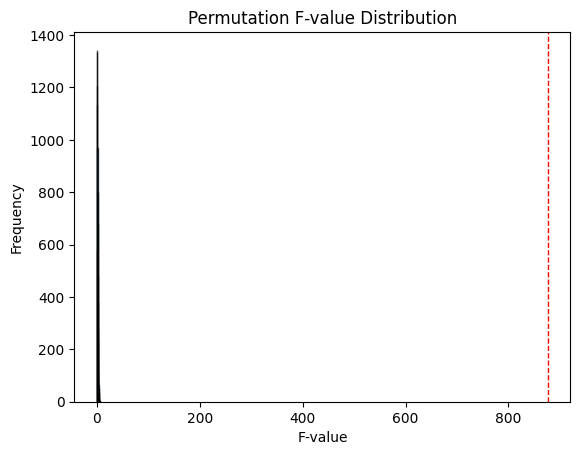

In [90]:
plt.hist(permuted_f_stats, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(observed_f, color='r', linestyle='dashed', linewidth=1)
plt.title('Permutation F-value Distribution')
plt.xlabel('F-value')
plt.ylabel('Frequency')
plt.show()


Because p = 0 < 0.05, we reject the null hypothesis, so the **mean total fines is significantly different** for each category. A strong correlation exists, but we do not have enough evidence to suggest there is a casual relationship in our data.

#### Machine Learning

In [117]:
smaller_provider_info['Abuse Icon'].unique()

array([0, 1])

In [118]:
smaller_provider_info.head()

CMS Certification Number (CCN) State            Ownership Type  \
0                         015009    AL  For profit - Corporation   
1                         015010    AL  For profit - Corporation   
2                         015012    AL       Government - County   
3                         015014    AL   For profit - Individual   
4                         015015    AL   For profit - Individual   

   Number of Certified Beds  Average Number of Residents per Day  \
0                        57                                 50.0   
1                        85                                 76.9   
2                        50                                 45.1   
3                        92                                 76.9   
4                       103                                 86.6   

           Provider Type Special Focus Status  Abuse Icon  Overall Rating  \
0  Medicare and Medicaid                  NaN           0             2.0   
1  Medicare and Medicaid                  NaN           0             4.0   
2  Medicare and Medicaid                  NaN           0             4.0   
3  Medicare and Medicaid                  NaN           0             2.0   
4  Medicare and Medicaid                  NaN           0             2.0   

   Health Inspection Rating  QM Rating  Staffing Rating  \
0                       2.0        4.0              4.0   
1                       4.0        4.0              3.0   
2                       4.0        2.0              3.0   
3                       3.0        3.0              1.0   
4                       2.0        2.0              4.0   

   Number of Citations from Infection Control Inspections  \
0                                                NaN        
1                                                0.0        
2                                                NaN        
3                                                0.0        
4                                                NaN        

   Total Amount of Fines in Dollars  
0                          24644.14  
1                              0.00  
2                              0.00  
3                              0.00  
4                              0.00

In [143]:
# pipeline imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer

# prepare dataset
smaller_provider_info = smaller_provider_info.dropna() # fix nan for special focus status, health inspection, and average number of residents per day
smaller_provider_info['Special Focus Status'] = smaller_provider_info['Special Focus Status'].fillna('Not Special Focus')

# Separate features (X) and target (y)
# Drop CMS because it is an identifier
X = smaller_provider_info.drop(columns=['CMS Certification Number (CCN)', 'Overall Rating'])
y = smaller_provider_info['Overall Rating']

# pipeline preprocessing 
categorical = ['State', 'Ownership Type', 'Provider Type', 'Special Focus Status', 'Abuse Icon']
quantitative = ['Number of Certified Beds', 'Average Number of Residents per Day', 'Health Inspection Rating', 'QM Rating',\
                'Staffing Rating', 'Number of Citations from Infection Control Inspections', 'Total Amount of Fines in Dollars']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical),
        ('num', StandardScaler(), quantitative)
    ]
)

# We will use a Logistic Regression model since we are predicted Overall Rating, a categorical variable
model = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(multi_class='multinomial', max_iter=1000))
    ]
)

# train = trains ML algorithm; test = used to evaluate the accuracy of the trained algorithm
# Split the data into training + test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X contains NaN -- impute


# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

classification_report(y_test, y_pred)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



'              precision    recall  f1-score   support\n\n         1.0       0.88      0.87      0.88       441\n         2.0       0.78      0.75      0.76       396\n         3.0       0.67      0.79      0.73       291\n         4.0       0.79      0.72      0.76       294\n         5.0       0.91      0.90      0.90       211\n\n    accuracy                           0.80      1633\n   macro avg       0.81      0.81      0.80      1633\nweighted avg       0.81      0.80      0.80      1633\n'

In [122]:
X.isna().sum()

State                                                     0
Ownership Type                                            0
Number of Certified Beds                                  0
Average Number of Residents per Day                       0
Provider Type                                             0
Special Focus Status                                      0
Abuse Icon                                                0
Health Inspection Rating                                  0
QM Rating                                                 0
Staffing Rating                                           0
Number of Citations from Infection Control Inspections    0
Total Amount of Fines in Dollars                          0
dtype: int64

In [106]:
px.box(smaller_provider_info, 'Average Number of Residents per Day')
# Heavily right-skewed -> impute missing data with median